# Geospatial Matching Optimization

This project is designed to showcase how to improve the speed of a polygon matching procedure. There are three main areas that could benefit from taking a "geospatial-native" approach:

1. Data encoding and fetching
2. Matching
3. Storage

We will generate synthetic polygon data and use both a non-geospatial-native and geospatial-native approach, comparing execution time for both to see how they differ.

## Imports

In [26]:
import random
import geopandas as gpd
import pandas as pd
import shapely
from shapely.geometry import Polygon, box
import h3
import time
import matplotlib.pyplot as plt
from shapely.wkt import dumps
from pathlib import Path

## Generate Test Data

In [ ]:

# Generate random polygons as blobs
def generate_random_polygons(n=100, bbox=(-100, -100, 100, 100)):
    """Generate n random polygons inside a bounding box."""
    minx, miny, maxx, maxy = bbox
    polygons = []
    for _ in range(n):
        x1, y1 = random.uniform(minx, maxx), random.uniform(miny, maxy)
        x2, y2 = x1 + random.uniform(1, 5), y1 + random.uniform(1, 5)
        polygons.append(box(x1, y1, x2, y2))  # Create rectangle
    return gpd.GeoDataFrame(geometry=polygons, crs="EPSG:4326")

In [9]:
# Create two months of blob data
prev_month_blobs = generate_random_polygons(n=10000)
curr_month_blobs = generate_random_polygons(n=10000)

In [25]:
prev_month_blobs.head()

,geometry
0,"POLYGON ((17.77566 -87.13806, 17.77566 -86.084..."
1,"POLYGON ((83.59024 -39.70595, 83.59024 -35.589..."
2,"POLYGON ((51.49452 95.49381, 51.49452 99.47730..."
3,"POLYGON ((-48.40663 -41.44200, -48.40663 -39.0..."
4,"POLYGON ((45.66968 -30.96558, 45.66968 -29.535..."


In [ ]:
# save as geoparquet

Path('data/').mkdir(exist_ok=True)

prev_month_blobs.to_parquet('data/prev_month_blobs.parquet')
curr_month_blobs.to_parquet('data/curr_month_blobs.parquet')

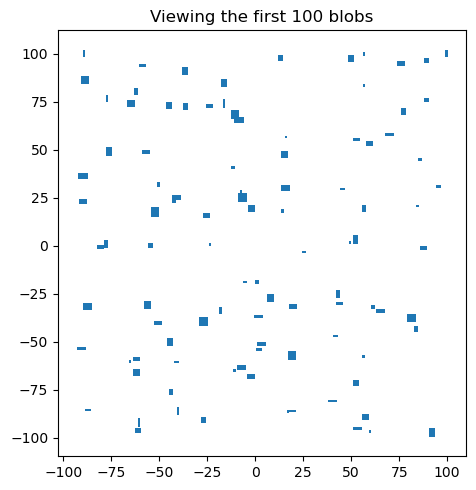

In [22]:
fig, ax = plt.subplots(figsize=(5, 5))
prev_month_blobs.iloc[0:100].plot(ax=ax)
ax.set_title('Viewing the first 100 blobs')
plt.tight_layout()

plt.show()

### Generate new set and convert polygon layer to non-geospatial-native string datatype

In [23]:
prev_month_blobs_str = generate_random_polygons(n=10000)
curr_month_blobs_str = generate_random_polygons(n=10000)

In [24]:
prev_month_blobs_str['geometry'] = prev_month_blobs_str['geometry'].apply(dumps)
curr_month_blobs_str['geometry'] = curr_month_blobs_str['geometry'].apply(dumps)

/var/folders/n3/q8wb235x57n_sx2q14dsngjr0000gn/T/ipykernel_65202/1073976832.py:1: UserWarning: Geometry column does not contain geometry.
  prev_month_blobs_str['geometry'] = prev_month_blobs_str['geometry'].apply(dumps)
/var/folders/n3/q8wb235x57n_sx2q14dsngjr0000gn/T/ipykernel_65202/1073976832.py:2: UserWarning: Geometry column does not contain geometry.
  curr_month_blobs_str['geometry'] = curr_month_blobs_str['geometry'].apply(dumps)


In [4]:
import functools

def timing_decorator(func):
    """Decorator to log function execution time."""
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        elapsed_time = time.time() - start_time
        print(f"Function `{func.__name__}` took {elapsed_time:.4f} seconds.")
        return result
    return wrapper

Baseline - Polygon Matching Only